# Meeting Minutes Generator (STT with LLMs)
---

- 🌍 Task: Generate structured meeting minutes from audio recordings using Speech-to-Text (STT) and Large Language Models
- 🧠 Models:
    - AUDIO_MODEL: whisper1
    - LLM_MODEL: meta-llama/Meta-Llama-3.1-8B-Instruct
- 🚀 Tools: Python, Gradio UI, OpenAI / HuggingFace APIs
- 📤 Output: Structured meeting minutes in Markdown format with real-time streaming
- 🧑‍💻 Skill Level: Intermediate

🎯 How It Works
- 1️⃣ Upload a .mp3 meeting recording
- 2️⃣ Submit the audio to generate meeting minutes in text format

You can download some meetings from this link to test the code:
[https://www.rmofspringfield.ca/p/meeting-audio-files](https://www.rmofspringfield.ca/p/meeting-audio-files)


🛠️ Requirements
- ⚙️ Hardware: ✅ GPU required (model download); Google Colab recommended (T4)
- 🔑 OpenAI API Key (used for whisper1 transcription)
- 🔑 Hugging Face Token (for the LLM model)

⚙️ Customizable by user
- 🤖 Selected model: AUDIO_MODEL / LLM_MODEL
- 📜 system_prompt: Controls model behavior (concise, accurate, structured output)
- 💬 user_prompt

---
📢 Find more LLM notebooks on my [GitHub repository](https://github.com/lisekarimi/lexo)

In [ ]:
# Install required packages in Google Colab
%pip install -q requests torch bitsandbytes transformers sentencepiece accelerate openai httpx==0.27.2 gradio

In [ ]:
# imports
import torch
import threading
from openai import OpenAI
from huggingface_hub import login
from google.colab import userdata
from transformers import AutoTokenizer, AutoModelForCausalLM, TextIteratorStreamer, BitsAndBytesConfig
import gradio as gr

In [ ]:
# Constants
AUDIO_MODEL = "whisper-1"  # OpenAI Whisper API model
LLM_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [ ]:
# Google Colab User Data
# Ensure you have set the following in your Google Colab environment:
hf_token = userdata.get('HF_TOKEN')
openai_api_key = userdata.get('OPENAI_API_KEY')

In [ ]:
login(hf_token, add_to_git_credential=True)
openai = OpenAI(api_key=openai_api_key)

In [ ]:
class MeetingAssistant:
    def __init__(self, model_name=LLM_MODEL, audio_model=AUDIO_MODEL):

        # Load tokenizer and llm model
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_quant_type="nf4"
        )

        self.audio_model = audio_model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            quantization_config=quant_config
        )

    def transcribe_audio(self, audio_path, progress):
        """Transcribes the uploaded audio file using OpenAI Whisper API."""

        progress(0.3, desc="Transcribing audio...")

        try:
            with open(audio_path, "rb") as audio_file:
                transcription = openai.audio.transcriptions.create(
                    model=self.audio_model,
                    file=audio_file,
                    response_format="text"
                )
                return transcription
        except Exception as e:
            return f"Error during transcription: {str(e)}"

    def generate_minutes(self, transcription, progress):
        """Generates meeting minutes from the transcript using the Llama model."""
        progress(0.6, desc="Generating meeting minutes...")

        system_message = "You are an assistant that produces minutes of meetings from transcripts, with summary, key discussion points, takeaways and action items with owners, in markdown."
        user_prompt = f"Below is an extract transcript of a meeting. Please write minutes in markdown, including a summary with attendees, location and date; discussion points; takeaways; and action items with owners.\n{transcription}"

        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_prompt}
        ]

        inputs = self.tokenizer.apply_chat_template(messages, return_tensors="pt").to("cuda")
        streamer = TextIteratorStreamer(self.tokenizer)

        thread = threading.Thread(
            target=self.model.generate, kwargs={
                    "input_ids": inputs,
                    "max_new_tokens": 2000,
                    "streamer": streamer
                  })
        thread.start()


        started = False
        # buffer = ""
        for new_text in streamer:
          if not started:
              if "<|start_header_id|>assistant<|end_header_id|>" in new_text:
                  started = True
                  new_text = new_text.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()

          if started:
              if "<|eot_id|>" in new_text:
                  new_text = new_text.replace("<|eot_id|>", "")  # Remove the unwanted token

              if new_text.strip():  # Only yield non-empty chunks
                  yield new_text

    def process_meeting(self, audio_file, progress):
        """Handles the complete process: transcribes audio and generates minutes."""
        progress(0.1, desc="Processing audio file...")

        # Check if a file is uploaded
        if audio_file is None:
            return "Please upload an audio file."

        try:
          # Check file format
          if not str(audio_file).lower().endswith('.mp3'):
              return "Please upload an MP3 file."

          # Get transcription
          transcription = self.transcribe_audio(audio_file, progress)

          # Generate minutes
          accumulated_text = ""
          minutes = self.generate_minutes(transcription, progress)
          for chunk in minutes:
            accumulated_text += chunk  # Append new text
            yield accumulated_text   # Update Gradio output with full text

        except Exception as e:
          return f"Error processing file: {str(e)}"

In [ ]:
class GradioInterface:
    def __init__(self):
        """Initializes the Gradio interface for processing audio files."""
        self.assistant = MeetingAssistant()
        self.iface = gr.Interface(
            fn=self.process_audio,
            inputs=gr.Audio(type="filepath", label="Upload MP3 File", format="mp3"),
            outputs=gr.Markdown(label="Meeting Minutes", min_height=60),
            title="AI Meeting Assistant",
            description="Upload an audio file to transcribe and generate meeting minutes.",
            flagging_mode="never"
        )

    def process_audio(self, audio_file, progress=gr.Progress()): # Adapter between the UI and the backend.
        """Handles user input from Gradio, processes the audio, and returns meeting minutes."""
        response = self.assistant.process_meeting(audio_file, progress)
        for chunk in response:
          yield chunk

    def launch(self):
        """Launches the Gradio interface."""
        self.iface.launch()

In [ ]:
if __name__ == "__main__":
    app = GradioInterface()
    app.launch()

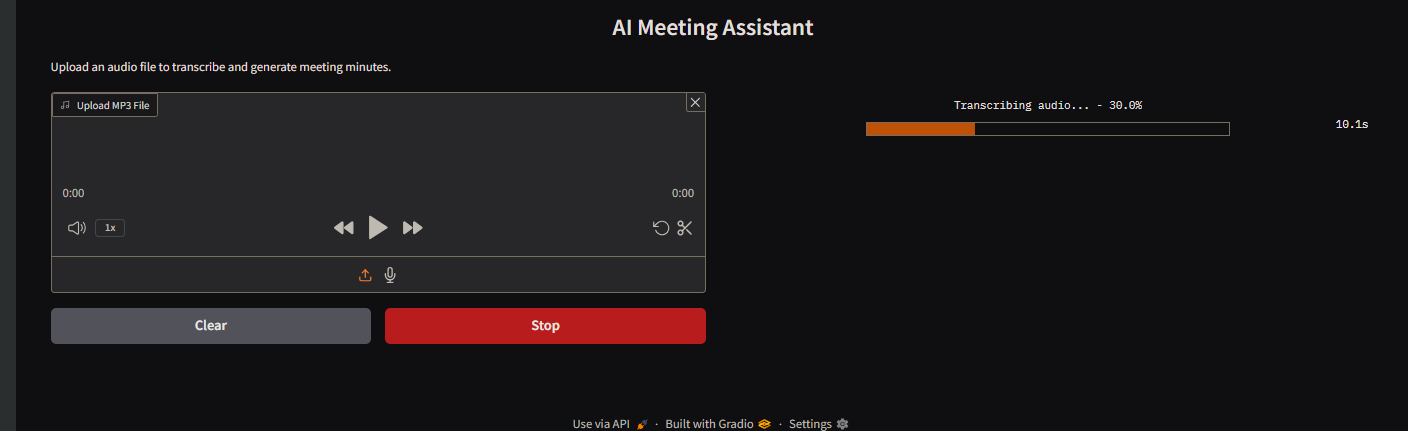

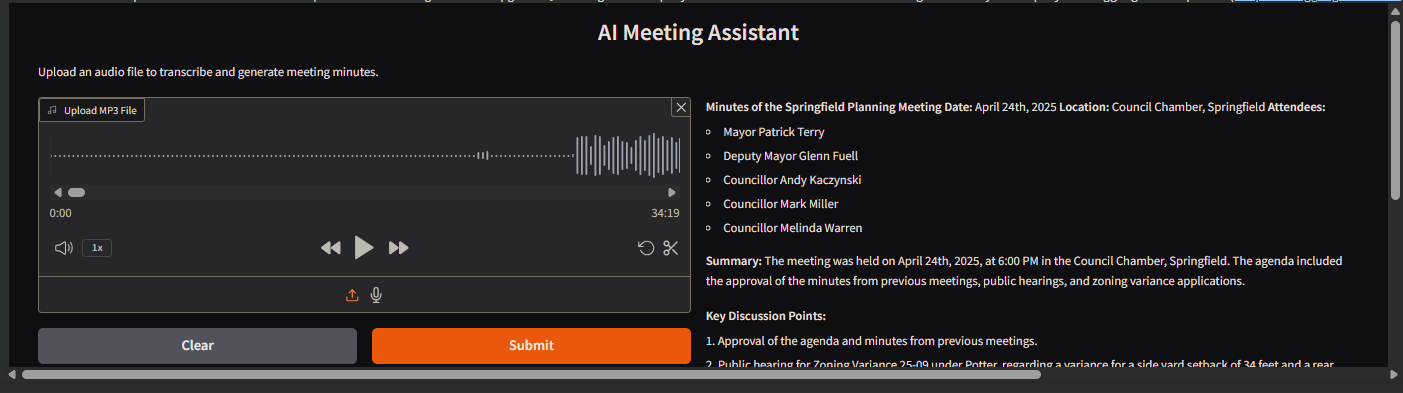